In [1]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


import sys

import pickle

In [2]:
# Load Algonauts data

with open('../algonauts_brain_data_joint_images_8subjects.pkl', 'rb') as f:
    brainData = pickle.load(f)

shared_images = np.load('../algonauts_joint_images_8subjects.npy')
clean_images = shared_images

In [3]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [ ]:
# 1000 Imagenet images, one from each category

fnames = [f for f in os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/') if not f.startswith(".")]

images = []
for ind in range(len(fnames)):
    image_path = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/' + fnames[ind]
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")

shared_images = images


bwimageidx = []
for i, num in enumerate([len(shared_images[i].shape) for i in range(len(shared_images))]):
    if num < 3:
        bwimageidx.append(i)
        shared_images[i] = np.repeat(shared_images[i][:, :, np.newaxis], 3, axis=2)
        

In [ ]:
# Extract representations resulting from probe inputs image_data for a list of models, and save them individually (takes a long time)

import extract_internal_reps

# internal_reps = []
# model_2nds = []
repDict = {}

model_names = ['resnet50']
weights = 'first'
# image_data = test_image_data[0:1000,:,:,:]
# clean_images = shared_images
batch_size = 32
perm = 0

# permutation = np.array([1, 2, 0])

# if not np.array_equal(np.sort(permutation), np.arange(3)):
#     raise ValueError(f"Permutation array must contain all unique indices from 0 to 2.")

if perm:
    image_data = []
    for i in range(len(shared_images)):
        # permutation = np.random.permutation(3)
        single_image = shared_images[i]
        single_image_perm = single_image[...,permutation[i]]
        image_data.append(single_image_perm)
    # image_data = np.array(image_data)
else:
    image_data = shared_images

for model in model_names:  #avail_models:
    repDict[model] = extract_internal_reps.get_model_activations(model, weights, image_data, batch_size=32, saverep = True, filename = 'algonauts_shared_images_colors_normal')
    print(model + " done")

In [ ]:
# Load some saved representations

repDict_cnormal = {}

model_names = ["resnet50", 'vit_b_16', 'dinov2_vitb14']

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_algonauts_shared_images_colors_normal.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_cnormal.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict_cnormal.keys()]
# internal_reps = [value[0] for value in repDict.values()]


resnet50


In [ ]:
layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict_cnormal[model_name].keys()])
    internal_reps.extend([value for value in repDict_cnormal[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict_cnormal[model_name].keys()]))


In [ ]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

internal_reps = [internal_rep/np.linalg.norm(internal_rep, ord=2) for internal_rep in internal_reps]

[internal_rep.shape for internal_rep in internal_reps]


In [10]:
import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1, whiten = False, alpha = 0.5)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
# cached = dd.cache(reps_pcs, returnGinv=False) # this part takes a long time
np.savez('../cached_matrices/Kx_cache_resnet50_vit_b_16_DINOv2_vitb14_algonauts_shared_a0b1_all_layers_colors_normal_opnorm.npz', cached, layer_names)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
Done caching.


In [54]:
# load previously computed cache

loaded_cache = np.load('../cached_matrices/Kx_cache_resnet50_vit_b_16_DINOv2_vitb14_algonauts_shared_a0b1_all_layers_colors_normal_opnorm.npz')

# cached = loaded_cache
cached = loaded_cache["arr_0"]
layer_names = loaded_cache["arr_1"]
layer_names = [str(layer_name) for layer_name in layer_names]

In [55]:
layer_names

['pixels',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc',
 'pixels',
 'conv_proj',
 'encoder_layer_0',
 'encoder_layer_1',
 'encoder_layer_2',
 'encoder_layer_3',
 'encoder_layer_4',
 'encoder_layer_5',
 'encoder_layer_6',
 'encoder_layer_7',
 'encoder_layer_8',
 'encoder_layer_9',
 'encoder_layer_10',
 'encoder_layer_11',
 'encoder',
 'heads',
 'pixels',
 'patch_embed',
 'block.0',
 'block.1',
 'block.2',
 'block.3',
 'block.4',
 'block.5',
 'block.6',
 'block.7',
 'block.8',
 'block.9',
 'block.10',
 'block.11',
 'norm',
 'head']

In [8]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]

# metric_type = 'similarity'
metric_type = 'distance'
plot = 'False'
p = 5 # dimension of the projection

# inds = list(range(0,17))
# inds = list(range(17,33))
# inds = list(range(34,49))

inds = list(range(0, len(layer_names)))

dist_mat = np.zeros((len(inds),len(inds)))

dist_task_dict = {}

count1 = 0


for ind1 in inds:
    count2 = 0
    KX = cached[ind1]
    
    for ind2 in inds:
        
        KY = cached[ind2]
        
        if metric_type == 'similarity':
            A = (1/2)*(KX@KY + KY@KX)
        elif metric_type == 'distance':
            A = (KX - KY)@(KX - KY)
        else:
            print('check metric type')
        
        vals, vecs = np.linalg.eig(A)
        
        idx = vals.argsort()[::-1]   
        vals = vals[idx]
        vecs = vecs[:,idx]

        Xw = KX@vecs[:,0:p]
        Yv = KY@vecs[:,0:p]

        if metric_type == 'similarity':
            # dist_mat[count1,count2] = (Xw.T @ Yv) /(np.linalg.norm(Xw) * np.linalg.norm(Yv))
            dist_mat[count1,count2] = np.trace((Xw.T @ Yv)) /(np.linalg.norm(Xw, ord='fro') * np.linalg.norm(Yv, ord='fro'))

        elif metric_type == 'distance':
            dist_mat[count1,count2] = np.linalg.norm(Xw/np.linalg.norm(Xw, ord='fro') - Yv/np.linalg.norm(Yv, ord='fro') , ord='fro' )     #vecs[:,0].T @ A @ vecs[:,0]

        dist_task_dict[(layer_names[ind1], layer_names[ind2])] = {
            'dist': dist_mat[count1,count2],
            'vec': vecs[:,0],
            'vals': vals,
            'KX': KX,
            'KY': KY}

        

        print(layer_names[ind1])
        print(layer_names[ind2])
        
        count2 += 1

        # Plotting

        if plot == 'True':

            x = KX@vecs[:,0]/np.linalg.norm(KX@vecs[:,0])
            y = KY@vecs[:,0]/np.linalg.norm(KY@vecs[:,0])

            # x = vecs[:,0]
            # y = vecs[:,1]

            # x = KX@Cz_1
            # y = KY@Cz_1

            fig, ax = plt.subplots(figsize=(15,15))
            ax.scatter(x, y) 
            # ax.set_xlim(-0.3, 0.6)
            # ax.set_ylim(-0.25, 0.75)

            axes = plt.gca()
            x_min, x_max = axes.get_xlim()
            y_min, y_max = axes.get_ylim()

            # Determine the range for the unity line to cover the visible area
            # Ensure the line extends across the relevant portion of the plot
            unity_line_min = max(x_min, y_min)
            unity_line_max = min(x_max, y_max)

            # Create x and y values for the unity line
            unity_x = np.linspace(unity_line_min, unity_line_max, 2)
            unity_y = unity_x

            # Plot the unity line
            ax.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


            zoom=0.04

            for x0, y0, imgdata in zip(x, y,images):
                img = OffsetImage(imgdata, zoom=zoom)
                # img = Image.fromarray(imgdata, 'RGB')
                ab = AnnotationBbox(img, (x0, y0), frameon=False)
                ax.add_artist(ab)

            plt.savefig('../layer_comparison_images/zxzy_' + metric_type + '_a0b1_' + layer_models[ind1] + '_' + layer_names[ind1] + '_' + layer_models[ind2] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)

            plt.close(fig)

#  --- IGNORE ---   <--- This is a comment
    # error_mat[count1] = np.linalg.norm(KX@vecs[:,0] - vecs[:,0])
    # error_mat_color[count1] = np.linalg.norm(KX@C@vecs_c[:,0] - C@vecs_c[:,0])

        
    count1 += 1

dist_task_dict['dist_mat'] = dist_mat

# Save the distance task dictionary to a file
with open('../layer_comparison_images/Resnet50_vit_b_16_DINOv2_vitb14_layer_by_layer_task_dict_' + metric_type + '_a0b1_' + 'algonauts_shared_images_p'+ str(p) +'.pkl', 'wb') as f:
    pickle.dump(dist_task_dict, f)

pixels
pixels
pixels
conv1
pixels
bn1
pixels
relu
pixels
maxpool
pixels
layer1
pixels
layer2
pixels
layer3
pixels
layer4
pixels
avgpool
pixels
fc
pixels
pixels
pixels
conv_proj
pixels
encoder_layer_0
pixels
encoder_layer_1
pixels
encoder_layer_2
pixels
encoder_layer_3
pixels
encoder_layer_4
pixels
encoder_layer_5
pixels
encoder_layer_6
pixels
encoder_layer_7
pixels
encoder_layer_8
pixels
encoder_layer_9
pixels
encoder_layer_10
pixels
encoder_layer_11
pixels
encoder
pixels
heads
pixels
pixels
pixels
patch_embed
pixels
block.0
pixels
block.1
pixels
block.2
pixels
block.3
pixels
block.4
pixels
block.5
pixels
block.6
pixels
block.7
pixels
block.8
pixels
block.9
pixels
block.10
pixels
block.11
pixels
norm
pixels
head
conv1
pixels
conv1
conv1
conv1
bn1
conv1
relu
conv1
maxpool
conv1
layer1
conv1
layer2
conv1
layer3
conv1
layer4
conv1
avgpool
conv1
fc
conv1
pixels
conv1
conv_proj
conv1
encoder_layer_0
conv1
encoder_layer_1
conv1
encoder_layer_2
conv1
encoder_layer_3
conv1
encoder_layer_4
conv

In [7]:
with open('../layer_comparison_images/Resnet50_Dinov2_layer_by_layer_task_dict_similarity_a0b1_' + 'algonauts_shared_images_p5.pkl', 'rb') as f:
    dist_task_dict = pickle.load(f)


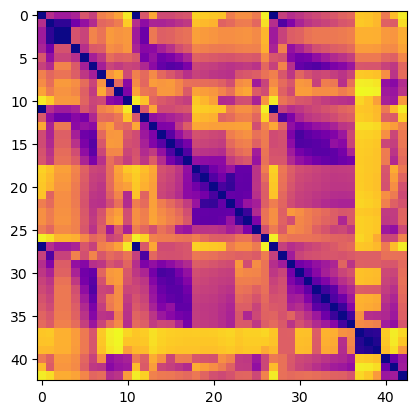

In [9]:
plt.imshow(dist_mat, cmap='plasma')

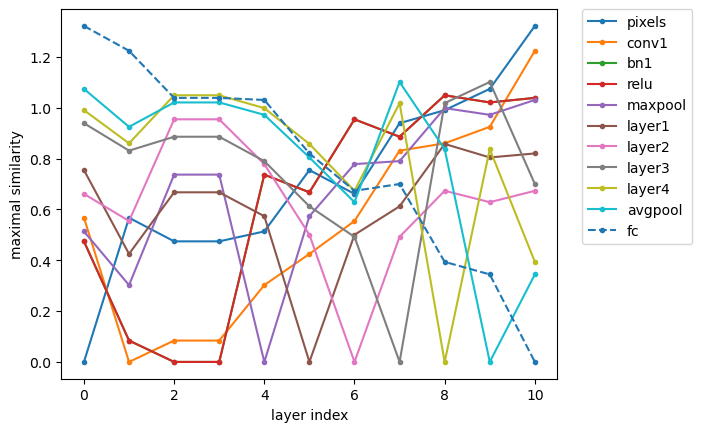

In [10]:
# for i in range(0,len(dist_mat)):
for i in range(0,11):

    # if i ==0:
    #     continue
    if i > 9:
        plt.plot(dist_mat[i,:11],'.--',label=layer_names[i])
    else:
        plt.plot(dist_mat[i,:11],'.-',label=layer_names[i])

    # plt.plot(dist_mat[i,:],'.-',label=layer_names[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)
    plt.xlabel('layer index')
    plt.ylabel('maximal similarity')

    # plt.savefig('../layer_comparison_images/DINOv2_layer_by_layer_' + metric_type + '_a0b1_algonauts_shared_images.pdf', dpi=500, bbox_inches='tight')
    
    # plt.yscale('log')

### Inspect 2 layers

In [157]:
ind1 = 9 #2 #13
ind2 = -1 #43 #35 #20 #30

metric_type = 'similarity'
# metric_type = 'distance'
# task = 'random'
task = 'max'

KX = cached[ind1]
KY = cached[ind2]

# KX = cached[ind1]/np.linalg.norm(cached[ind1], ord='fro')
# KY = cached[ind2]/np.linalg.norm(cached[ind2], ord='fro')

if metric_type == 'similarity':
    A = (1/2)*(KX@KY + KY@KX)
    # A = (1/2)*(C.T @ KX@KY @ C + C.T @ KY@KX @ C)
elif metric_type == 'distance':
    # A = C.T @ (KX - KY)@(KX - KY) @ C
    A = (KX - KY)@(KX - KY)
else:
    print('check metric type')

# A = (1/2)*(KY@KY - KY + KX - KX@KY)@(KY@KY - KY + KX - KY@KX)

if task == 'random':
    z = np.random.rand(KX.shape[0],2)
    vecs = z
else:
    vals, vecs = np.linalg.eig(A)

    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]

print(layer_names[ind1])
print(layer_names[ind2])

print(vecs[:,0].T @ A @ vecs[:,0])

avgpool
head
4.4161975e-08


In [158]:
np.linalg.norm(KX@vecs[:,0] - KY@vecs[:,0])

np.float32(0.0008807401)

In [159]:
np.linalg.norm(KX@vecs[:,0] )

np.float32(5.7468962e-05)

In [160]:
np.linalg.norm(KY@vecs[:,0] )

np.float32(0.00092775235)

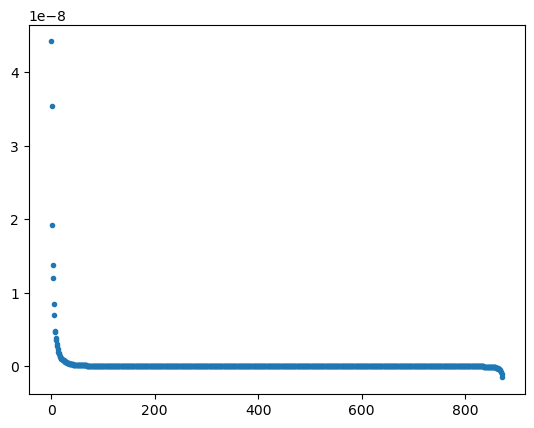

In [161]:
plt.plot(vals,'.')

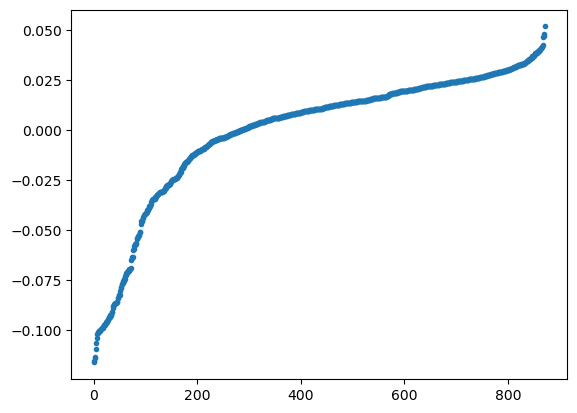

In [162]:
# Pick an eigenvector z

zind = 0

sorted_img_idx = vecs[:,zind].argsort()[::-1]
plt.plot(np.sort(vecs[:,zind]),'.')

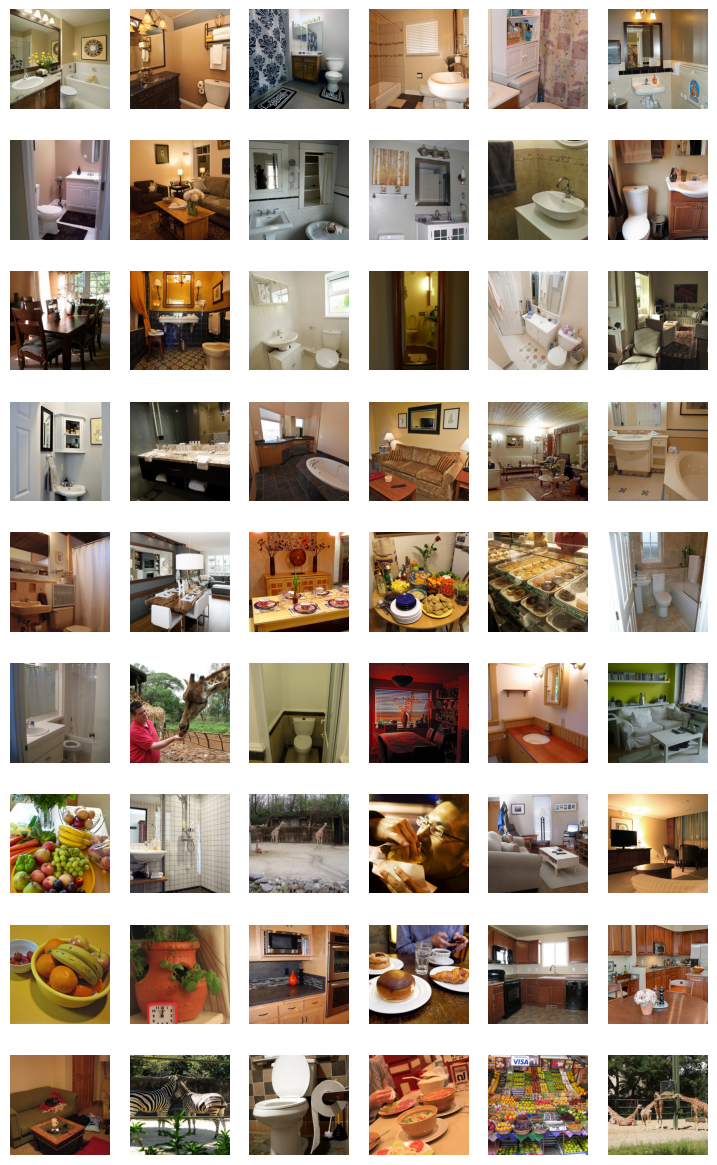

In [163]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = 0

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind += 1

# plt.savefig('maxmin_image_tiles/distance_maxweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()



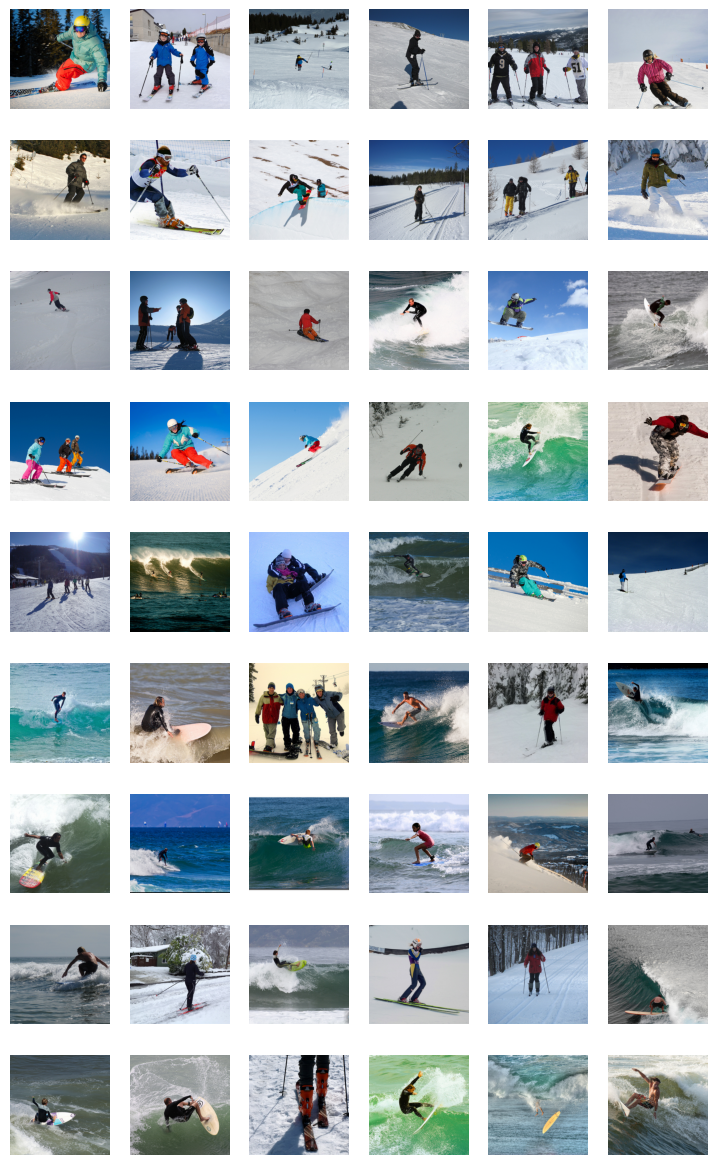

In [164]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = -1

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind -= 1

# plt.savefig('maxmin_image_tiles/distance_minweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()

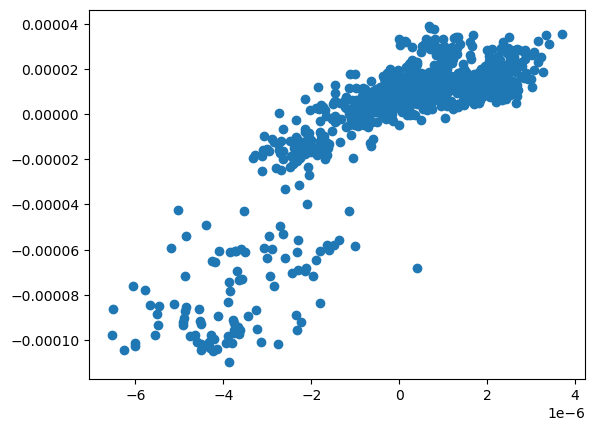

In [165]:
plt.scatter(KX@vecs[:,0], KY@vecs[:,0])

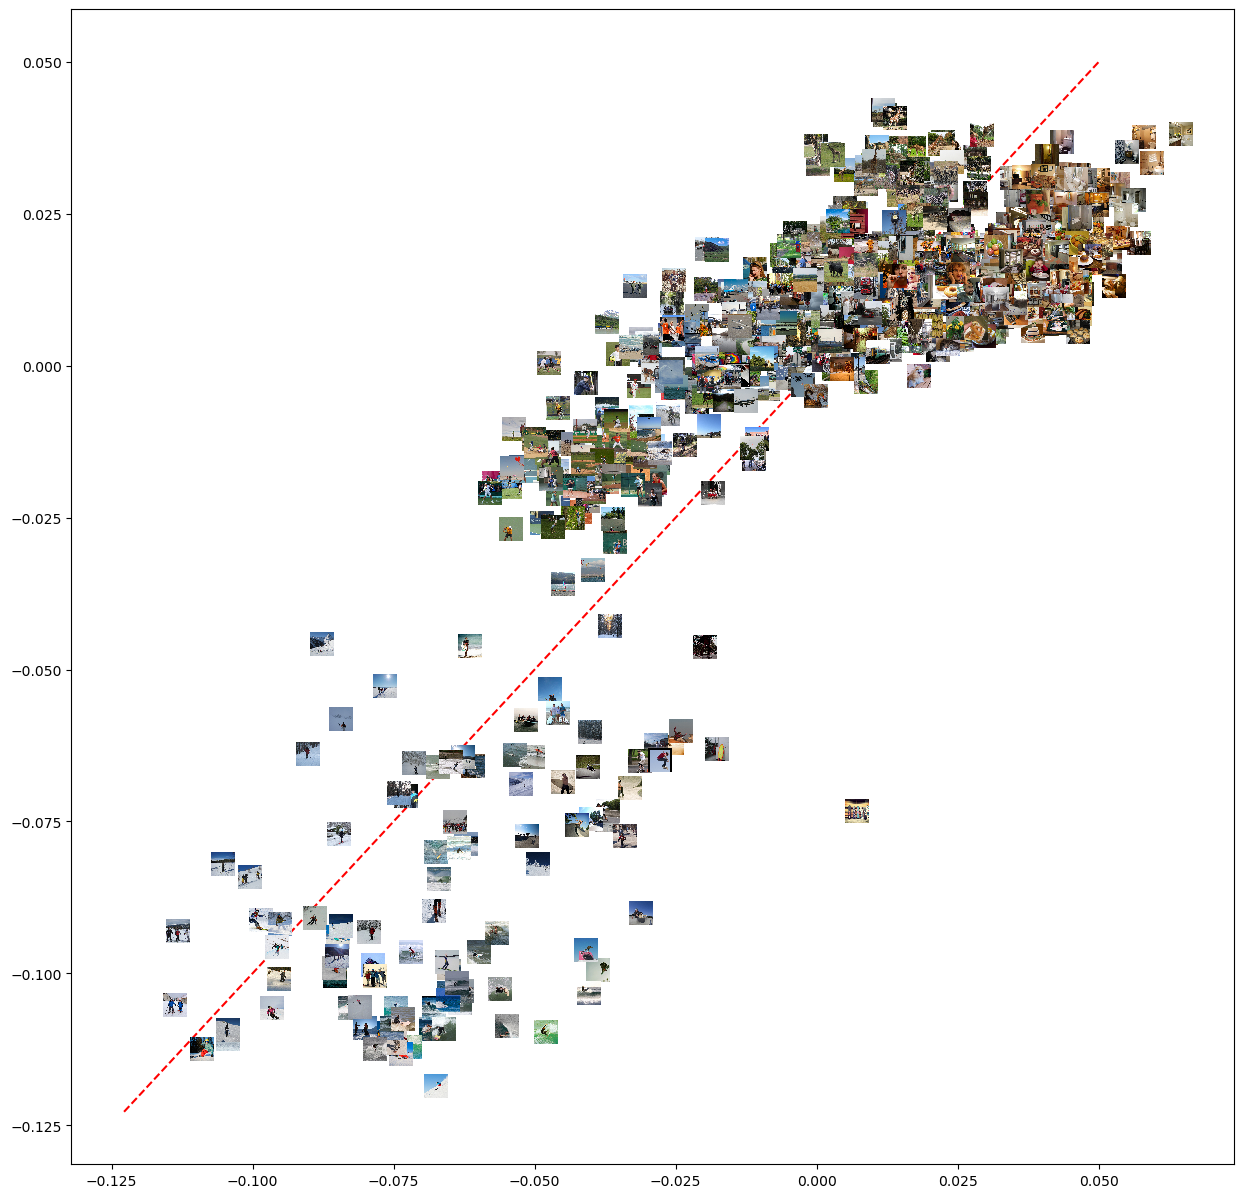

In [167]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]

vecind = 0

x = KX@vecs[:,vecind]/np.linalg.norm(KX@vecs[:,vecind])
y = KY@vecs[:,vecind]/np.linalg.norm(KY@vecs[:,vecind])

# x = KX@vecs[:,vecind]
# y = KY@vecs[:,vecind]

# x = vecs[:,0]
# y = vecs[:,1]

# x = KX@Cz_1
# y = KY@Cz_1

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y) 
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Determine the range for the unity line to cover the visible area
# Ensure the line extends across the relevant portion of the plot
unity_line_min = max(x_min, y_min)
unity_line_max = min(x_max, y_max)

# Create x and y values for the unity line
unity_x = np.linspace(unity_line_min, unity_line_max, 2)
unity_y = unity_x

# Plot the unity line
plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


zoom=0.04

for x0, y0, imgdata in zip(x, y,images):
    img = OffsetImage(imgdata, zoom=zoom)
    # img = Image.fromarray(imgdata, 'RGB')
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)
# 
# plt.savefig('../maxmin_image_tiles/zxzy_'+ metric_type +'_' + task + '_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + '_algonauts_shared_images_1.pdf', dpi=500)
# 
    

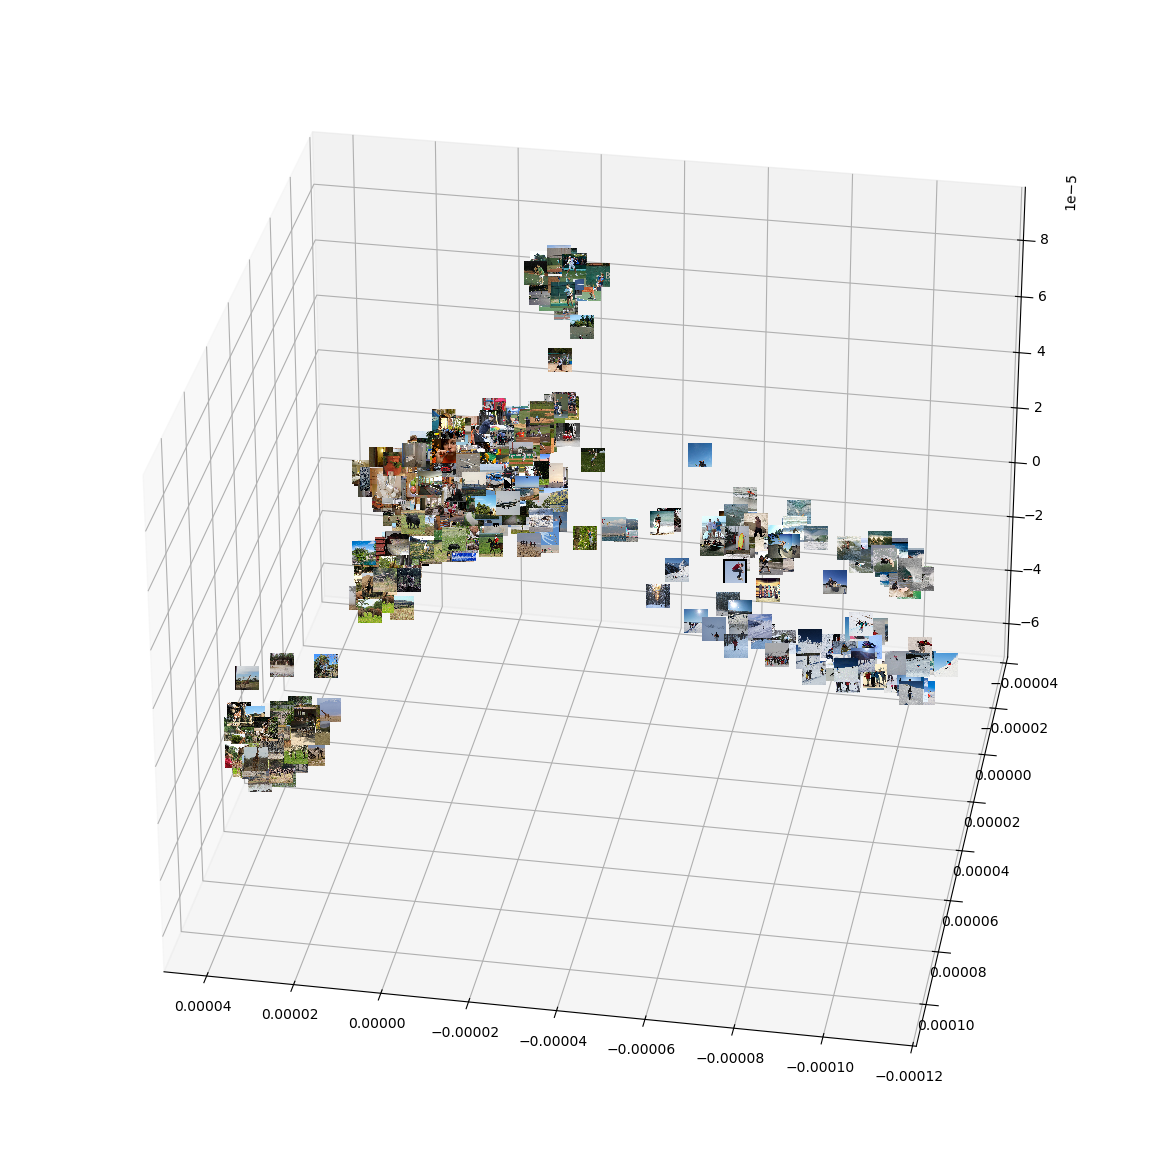

In [168]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D  # Needed to create 3D axes
import numpy as np

from matplotlib.animation import FuncAnimation

def getImage(imgdata, zoom=1):
    return OffsetImage(imgdata, zoom=zoom)


# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]

vecind = 0

# x = vecs[:,-1]
# y = vecs[:,-2]

# x = KX@vecs[:,vecind]
# y = KX@vecs[:,vecind+1]
# z = KX@vecs[:,vecind+2]

x = KY@vecs[:,vecind]
y = KY@vecs[:,vecind+1]
z = KY@vecs[:,vecind+2]

# x = KX@Cz_1
# y = KY@Cz_1

# fig, ax = plt.subplots(figsize=(15,15), projection='3d')
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='k') 
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# # Determine the range for the unity line to cover the visible area
# # Ensure the line extends across the relevant portion of the plot
# unity_line_min = max(x_min, y_min)
# unity_line_max = min(x_max, y_max)

# # Create x and y values for the unity line
# unity_x = np.linspace(unity_line_min, unity_line_max, 2)
# unity_y = unity_x

# # Plot the unity line
# plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


zoom=0.04

# # To project 3D coords to 2D display space
# from mpl_toolkits.mplot3d.proj3d import proj_transform

# # Define the animation function
# def rotate(angle):
#     ax.view_init(azim=angle)
#     return ax.scatter,

ax.view_init(elev=30, azim=100) # Elevation and Azimuth angles


for x0, y0, z0, imgdata in zip(x, y, z, images):
    x2, y2, _ = proj_transform(x0, y0, z0, ax.get_proj())  # Project 3D to 2D
    img = getImage(imgdata, zoom=zoom)
    ab = AnnotationBbox(img, (x2, y2), frameon=False, xycoords='data')
    ax.figure.gca().add_artist(ab)


# # Create the animation
# num_frames = 5  # Number of frames for a full rotation
# animation = FuncAnimation(fig, rotate, frames=num_frames, interval=20, blit=False)

# # Save the animation as a video
# animation.save('ADS_a0b1_top3eigvecs_rotating_scatter_plot_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[2] + '_' + layer_names[ind2] + '_' +  model_names[0] + 'projection' + '.gif', writer='ffmpeg', fps=30, dpi=300)

# 
# plt.savefig('../maxmin_image_tiles/projection2d_'+ metric_type +'_' + task  +'_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)
# 
    

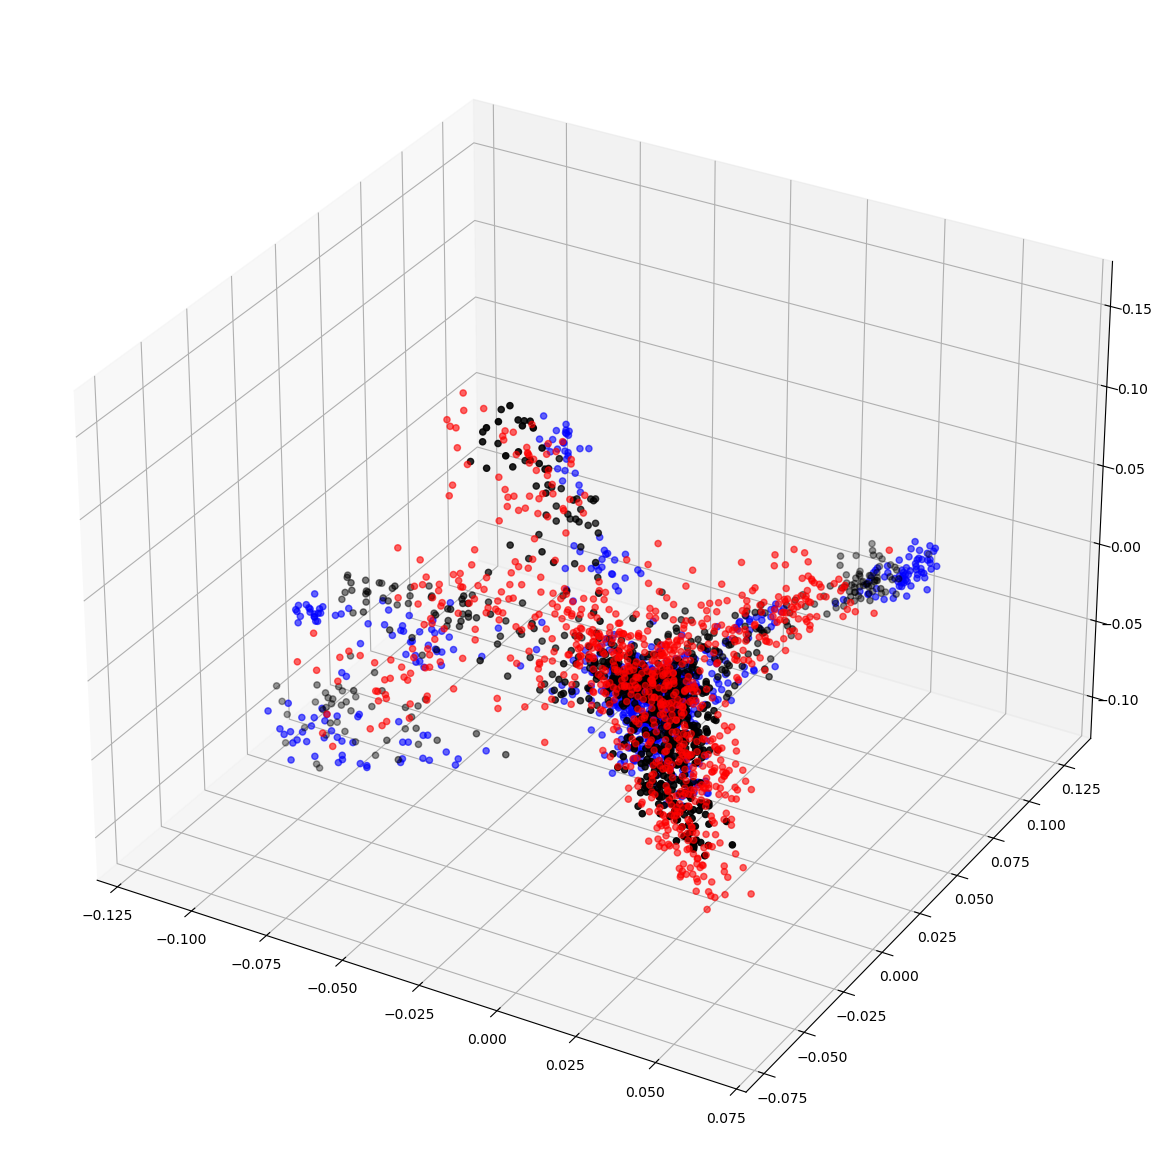

In [169]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]


x = vecs[:,0].real
y = vecs[:,1].real
z = vecs[:,2].real

x1 = KX@vecs[:,0].real /np.linalg.norm(KX@vecs[:,0]) .real
y1 = KX@vecs[:,1].real /np.linalg.norm(KX@vecs[:,1]).real
z1 = KX@vecs[:,2].real /np.linalg.norm(KX@vecs[:,2]).real

x2 = KY@vecs[:,0].real/np.linalg.norm(KY@vecs[:,0]).real
y2 = KY@vecs[:,1].real/np.linalg.norm(KY@vecs[:,1]).real
z2 = KY@vecs[:,2].real/np.linalg.norm(KY@vecs[:,2]).real

# x = KX@Cz_1
# y = KY@Cz_1

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='k') 
ax.scatter(x1, y1, z1, color='r', alpha=0.6)
ax.scatter(x2, y2, z2, color='b',alpha=0.6)
# # Connect corresponding points in (x, y) and (x1, y1)
# for xi, yi, xi1, yi1 in zip(x, y, x1, y1):
#     ax.plot([xi, xi1], [yi, yi1], color='gray', linewidth=1, alpha=0.7)
# # Connect corresponding points in (x, y) and (x2, y2)
# for xi, yi, xi2, yi2 in zip(x, y, x2, y2):
#     ax.plot([xi, xi2], [yi, yi2], color='gray', linewidth=1, alpha=0.5)
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# # Determine the range for the unity line to cover the visible area
# # Ensure the line extends across the relevant portion of the plot
# unity_line_min = max(x_min, y_min)
# unity_line_max = min(x_max, y_max)

# # 
# or the unity line
# unity_x = np.linspace(unity_line_min, unity_line_max, 2)
# unity_y = unity_x

# # Plot the unity line
# plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


# plt.savefig('../maxmin_image_tiles/projection2d_'+ metric_type +'_' + task  +'_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)
# 
    

In [171]:
(vecs[:,0].T @ KX @vecs[:,0] + vecs[:,1].T @ KX @vecs[:,1] +vecs[:,2].T @ KX @vecs[:,2]) /np.linalg.trace(KX)

np.float32(0.15169558)

In [172]:
(vecs[:,0].T @ KY @vecs[:,0] + vecs[:,1].T @ KY @vecs[:,1] + vecs[:,2].T @ KY @vecs[:,1]) /np.linalg.trace(KY)

np.float32(0.06937733)

In [179]:
np.linalg.trace(vecs[:,:40].T @ KX @vecs[:,:40]) / np.linalg.trace(KX)

np.float32(0.57777625)

In [180]:
var_explained_KX = [np.linalg.trace(vecs[:,:i].T @ KX @vecs[:,:i]) / np.linalg.trace(KX) for i in range(len(KX))]

In [184]:
var_explained_KY = [np.linalg.trace(vecs[:,:i].T @ KY @vecs[:,:i]) / np.linalg.trace(KY) for i in range(len(KY))]

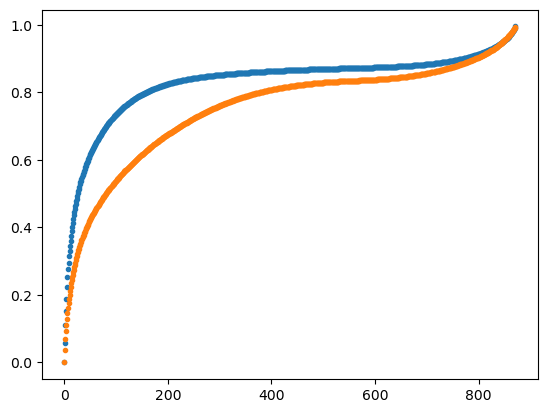

In [185]:
plt.plot(var_explained_KX,'.')
plt.plot(var_explained_KY,'.')

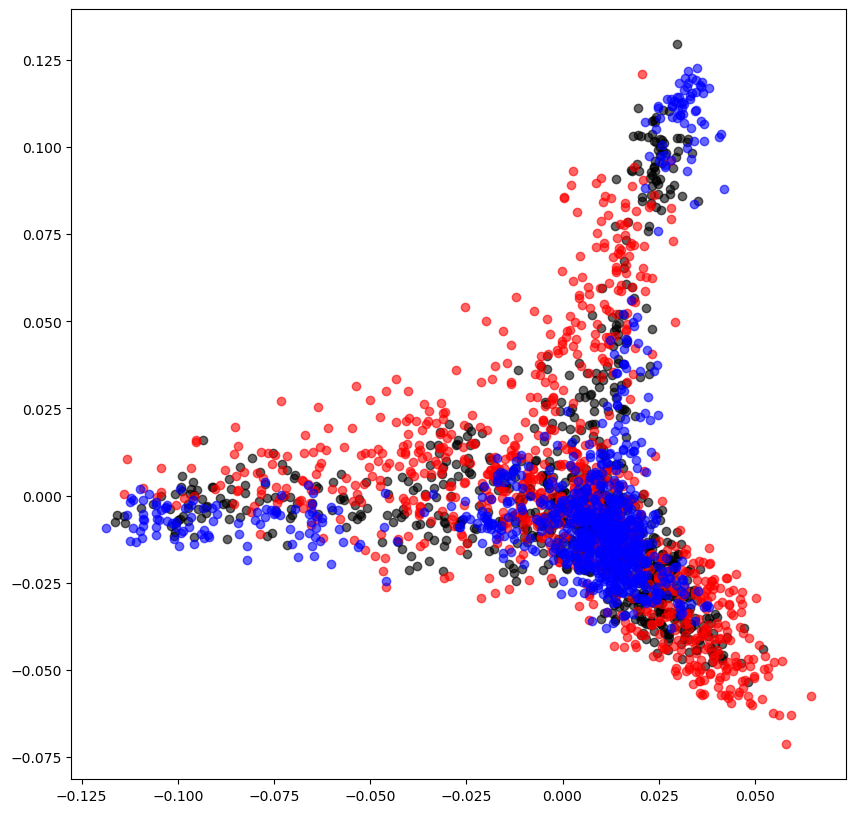

In [186]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]


x = vecs[:,0]
y = vecs[:,1]

x1 = KX@vecs[:,0]/np.linalg.norm(KX@vecs[:,0])
y1 = KX@vecs[:,1]/np.linalg.norm(KX@vecs[:,1])

x2 = KY@vecs[:,0]/np.linalg.norm(KY@vecs[:,0])
y2 = KY@vecs[:,1]/np.linalg.norm(KY@vecs[:,1])

# x = KX@Cz_1
# y = KY@Cz_1

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, color='k', alpha=0.6) 
ax.scatter(x1, y1, color='r', alpha=0.6)
ax.scatter(x2, y2, color='b',alpha=0.6)
# # Connect corresponding points in (x, y) and (x1, y1)
# for xi, yi, xi1, yi1 in zip(x, y, x1, y1):
#     ax.plot([xi, xi1], [yi, yi1], color='gray', linewidth=1, alpha=0.7)
# # Connect corresponding points in (x, y) and (x2, y2)
# for xi, yi, xi2, yi2 in zip(x, y, x2, y2):
#     ax.plot([xi, xi2], [yi, yi2], color='gray', linewidth=1, alpha=0.5)
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# # Determine the range for the unity line to cover the visible area
# # Ensure the line extends across the relevant portion of the plot
# unity_line_min = max(x_min, y_min)
# unity_line_max = min(x_max, y_max)

# # 
# or the unity line
# unity_x = np.linspace(unity_line_min, unity_line_max, 2)
# unity_y = unity_x

# # Plot the unity line
# plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


# plt.savefig('../maxmin_image_tiles/projection2d_'+ metric_type +'_' + task  +'_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)
# 
    

In [38]:
print(x1.T @ x)
print(y1.T @ y)


(0.8764012+0j)
(0.78909934+0j)


In [39]:
print(x2.T @ x)
print(y2.T @ y)

(0.9998264+0j)
(0.99966097+0j)


In [40]:
print(x1.T @ x2)
print(y1.T @ y2)

(0.8852204+0j)
(0.8048318+0j)


## Compare with NSD dataset

In [190]:
# Append some brain data to the list of representations


# areas = ['lh_FFA-1', 'rh_FFA-1', 'lh_FFA-2', 'rh_FFA-2']
# areas = ['lh_all-faces', 'rh_all-faces']
# areas = ['lh_all-words', 'rh_all-words']
# areas = ["lh_V1v", "rh_V1v", "lh_V1d", "rh_V1d"]
# areas = ['lh_OWFA', 'rh_OWFA']
# areas_both_hemi = ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"] 

hemisphere = "lh"  # lh, rh, or both
areas_to_append = ["hV4"] 
fuse = True


areas = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]
# areas = @param all_areas {allow-input: true}


for subjind in range(len(brainData)):
    for area in areas:
        if brainData[subjind][area].shape[1] == 0:
            continue
        internal_reps.append(brainData[subjind][area]/np.linalg.norm(brainData[subjind][area], ord=2))
        layer_names.append("Subject_" + str(subjind) + '_' + area)
        layer_models.append("Subject_" + str(subjind))




In [203]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]


[(872, 150528),
 (872, 802816),
 (872, 802816),
 (872, 802816),
 (872, 200704),
 (872, 802816),
 (872, 401408),
 (872, 200704),
 (872, 100352),
 (872, 2048),
 (872, 1000),
 (872, 150528),
 (872, 150528),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 1000),
 (872, 150528),
 (872, 196608),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 197376),
 (872, 606),
 (872, 457),
 (872, 547),
 (872, 584),
 (872, 439),
 (872, 540),
 (872, 538),
 (872, 531),
 (872, 606),
 (872, 457),
 (872, 547),
 (872, 584),
 (872, 439),
 (872, 540),
 (872, 538)]

In [ ]:
import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1, whiten = False, alpha = 0.5)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
# cached = dd.cache(reps_pcs, returnGinv=False) # this part takes a long time
np.savez('../cached_matrices/Kx_cache_resnet50_vit_b_16_DINOv2_vitb14_lh-hV4_algonauts_shared_a0b1_all_layers_colors_normal_opnorm.npz', cached, layer_names)


